# Predicting Critic Scores using Video Game Statistics

## Team Members: Ram S IMT2017521, Rathin Bhargava IMT201722

## Reading Data and Importing Libraries

In [1]:
import random
from math import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
data = pd.read_csv("Video_Games_Sales_as_at_22_Dec_2016.csv")
data.shape

(16719, 16)

## Data Visualization and Preprocessing

In [3]:
print(len(data.columns))
data.head(2)

16


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN


#### Since we are predicting MetaCritic score for games, we will drop all the data points which do not have a MetaCritic Score.

In [4]:
data = data.dropna(subset=['Critic_Score'])
data.shape

(8137, 16)

In [5]:
data.describe()

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Count
count,7983.000000,8137.000000,8137.000000,8137.000000,8137.000000,8137.000000,8137.000000,8137.000000,7017.000000
mean,2007.192785,0.352980,0.208311,0.055028,0.072435,0.689035,68.967679,26.360821,173.432664
std,4.189425,0.896476,0.635622,0.265075,0.249204,1.816704,13.938165,18.980495,581.977516
min,1985.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,4.000000
25%,2004.000000,0.050000,0.010000,0.000000,0.010000,0.090000,60.000000,12.000000,11.000000
50%,2007.000000,0.130000,0.050000,0.000000,0.020000,0.240000,71.000000,21.000000,27.000000
75%,2010.000000,0.340000,0.180000,0.010000,0.060000,0.650000,79.000000,36.000000,89.000000
max,2016.000000,41.360000,28.960000,6.500000,10.570000,82.530000,98.000000,113.000000,10665.000000


#### Number of Null values in each column

In [6]:
for i in list(data.columns):
        print (i,":",data[i].isnull().sum())

Name : 0
Platform : 0
Year_of_Release : 154
Genre : 0
Publisher : 4
NA_Sales : 0
EU_Sales : 0
JP_Sales : 0
Other_Sales : 0
Global_Sales : 0
Critic_Score : 0
Critic_Count : 0
User_Score : 38
User_Count : 1120
Developer : 6
Rating : 83


#### None of these columns seems to have more than 20% of their values missing. Therefore, we don't think we should be removing any more columns from the data set

#### Let us see the data type of each column

In [7]:
for i in list(data.columns):
    print(i,":",data[i].dtypes)

Name : object
Platform : object
Year_of_Release : float64
Genre : object
Publisher : object
NA_Sales : float64
EU_Sales : float64
JP_Sales : float64
Other_Sales : float64
Global_Sales : float64
Critic_Score : float64
Critic_Count : float64
User_Score : object
User_Count : float64
Developer : object
Rating : object


#### As we can see, every column has the required data type except User_Score which is an object instead of float64

### Sampler Function

#### When it comes to replacing null values, we can replace them with the mean value of that column, or the median.
#### We can also create a probability distribution based on the given data in that column and can perform Markov Chain Monte Carlo (MCMC) sampling on that distribution to fill the null values.
#### However, the sampler itself is good for generating data but might not perform well for replacing null values

#### Code for MCMC sampling

In [8]:
def sampler(s,data):
    d = dict(data[s].value_counts())
    sum1 = sum(d.values())
    m = d.keys()
    prob = [d[x]/float(sum1) for x in d.keys()]
#     print(prob)
    return [d.keys(),prob]

def sample(composite):
    key = list(composite[0])
    prob = composite[1]
    a = random.random()
    sofar = 0
    for i in range(len(key)):
        sofar += prob[i]
        if(a <= sofar):
            return key[i]
    return key[len(key)-1]

def replace_null(s,data):
    composite = sampler(s,data)
    l = list(data[s])
    for i in range(len(l)):
        if(pd.isna(l[i])):
            l[i] = sample(composite)
    data[s]=l

### Columnwise Analysis

### Year of Release

In [9]:
print(len(data['Year_of_Release'].unique()))
print(sorted(list(data['Year_of_Release'].unique())))

26
[1985.0, 1988.0, 1992.0, 1994.0, 1996.0, 1997.0, 1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0, 2015.0, 2016.0, nan]


#### The year of release might have some importance when it comes to Critic_Score. However, there are 26 values and the order of importance of this feature might not correlate chronologically. 

#### We will now populate the nan values in the data set.

In [10]:
# replace_null("Year_of_Release",data)
# data['Year_of_Release'] = data['Year_of_Release'].replace(0.0,2002.0)
data['Year_of_Release'] = data['Year_of_Release'].replace(0.0,data['Year_of_Release'].mean())

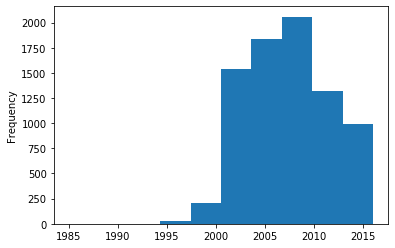

In [11]:
data['Year_of_Release'].plot(kind='hist')

#### Outlier detection

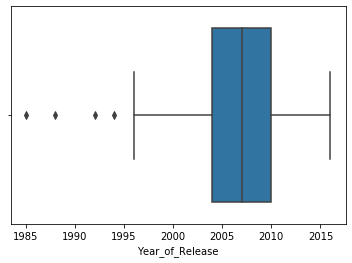

In [12]:
sns.boxplot(x=data['Year_of_Release'])

### Feature Engineering - Year_of_Release

#### We will be performing some feature engineering. We will create a new feature which reflect games released in that generation. This is because the exact year seems to be not very related to the score and we do not wish to suppose a 

In [13]:
#1985 - 1995
data['Year_198595'] = data[data['Year_of_Release'] <= 1995]['Year_of_Release']
data['Year_198595'] = data['Year_198595'].replace(np.nan, 0)
print(sorted(data['Year_198595'].unique()))
for i in sorted(data['Year_198595'].unique()):
    if(i!=0.0):
        data['Year_198595'] = data['Year_198595'].replace(i, 1)
print(sorted(data['Year_198595'].unique()))

#1996 - 2005
data['Year_199505'] = data[data['Year_of_Release'] <= 2005]['Year_of_Release']
data['Year_199505'] = data[data['Year_199505'] > 1995]['Year_199505']
data['Year_199505'] = data['Year_199505'].replace(np.nan, 0)
print(sorted(data['Year_199505'].unique()))
for i in sorted(data['Year_199505'].unique()):
    if(i!=0.0):
        data['Year_199505'] = data['Year_199505'].replace(i, 1)
# print(sorted(data['Year_199505'].unique()))

#2006 - 2010
data['Year_200510'] = data[data['Year_of_Release'] <= 2010]['Year_of_Release']
data['Year_200510'] = data[data['Year_200510'] > 2005]['Year_200510']
data['Year_200510'] = data['Year_200510'].replace(np.nan, 0)
print(sorted(data['Year_200510'].unique()))
for i in sorted(data['Year_200510'].unique()):
    if(i!=0.0):
        data['Year_200510'] = data['Year_200510'].replace(i, 1)
# print(sorted(data['Year_200510'].unique()))

#2010 - beyond
data['Year_201016'] = data[data['Year_of_Release'] > 2010]['Year_of_Release']
data['Year_201016'] = data['Year_201016'].replace(np.nan, 0)
print(sorted(data['Year_201016'].unique()))
for i in sorted(data['Year_201016'].unique()):
    if(i!=0.0):
        data['Year_201016'] = data['Year_201016'].replace(i, 1)
# print(sorted(data['Year_201016'].unique()))


data.shape

[0.0, 1985.0, 1988.0, 1992.0, 1994.0]
[0.0, 1.0]
[0.0, 1996.0, 1997.0, 1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0]
[0.0, 2006.0, 2007.0, 2008.0, 2009.0, 2010.0]
[0.0, 2011.0, 2012.0, 2013.0, 2014.0, 2015.0, 2016.0]


(8137, 20)

In [14]:
# platform_data.mean()

group_by_year = data.groupby(by=['Year_of_Release'])
year_data_avg = group_by_year.mean()
year_data_count = group_by_year.count()


data_count_series = year_data_count.iloc[:,0]

features_of_interest = pd.DataFrame({'Critic_Score':year_data_avg['Critic_Score'],'No. Games':data_count_series,})

features_of_interest

,Critic_Score,No. Games
Year_of_Release,,
1985.0,59.000000,1
1988.0,64.000000,1
1992.0,85.000000,1
1994.0,69.000000,1
1996.0,89.875000,8
1997.0,85.294118,17
1998.0,81.821429,28
1999.0,75.769231,39
2000.0,69.349650,143


#### We still believe that we cannot drop the Year_of_Release feature because it will help with the training. However, the partitions we have made were big turning points in gaming technology as well as general trends in gamer expectations.

In [15]:
data.head(2)

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Year_198595,Year_199505,Year_200510,Year_201016
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E,0.0,0.0,1.0,0.0
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E,0.0,0.0,1.0,0.0


### Platform

In [16]:
platform_data = data.groupby(by=['Platform'])
platform_data.count()

,Name,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Year_198595,Year_199505,Year_200510,Year_201016
Platform,,,,,,,,,,,,,,,,,,,
3DS,168,166,168,168,168,168,168,168,168,168,168,168,158,168,167,168,168,168,168
DC,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14
DS,717,708,717,717,717,717,717,717,717,717,717,712,469,717,715,717,717,717,717
GBA,438,430,438,438,438,438,438,438,438,438,438,434,241,438,438,438,438,438,438
GC,448,437,448,448,448,448,448,448,448,448,448,448,356,448,448,448,448,448,448
PC,715,699,715,713,715,715,715,715,715,715,715,706,703,714,677,715,715,715,715
PS,200,196,200,200,200,200,200,200,200,200,200,193,156,200,196,200,200,200,200
PS2,1298,1275,1298,1297,1298,1298,1298,1298,1298,1298,1298,1298,1161,1298,1298,1298,1298,1298,1298
PS3,820,804,820,819,820,820,820,820,820,820,820,819,790,819,813,820,820,820,820


In [17]:

group_by_platform = data.groupby(by=['Platform'])
platform_data_avg = group_by_platform.mean()
platform_data_count = group_by_platform.count()


In [18]:
data_count_series = platform_data_count.iloc[:,0]

features_of_interest = pd.DataFrame({'Critic_Score':platform_data_avg['Critic_Score'],'No. Games':data_count_series,})

features_of_interest

,Critic_Score,No. Games
Platform,,
3DS,67.101190,168
DC,87.357143,14
DS,63.761506,717
GBA,67.372146,438
GC,69.488839,448
PC,75.928671,715
PS,71.515000,200
PS2,68.727273,1298
PS3,70.382927,820


#### It might be relevant if we could classify the consoles into four families - Sony, Microsoft, Nintendo, Others. Also we could engineer 3 new features called 'Type' which will specify if the device is a handheld/console/pc. 

#### Device Type

In [19]:
#Handheld
data['Handheld'] = data[data['Platform'].isin(['3DS','DS','GBA','GC','PSP','PSV'])]['Platform']
data['Handheld'] = data['Handheld'].replace(np.nan, 0)
print((data['Handheld'].unique()))
for i in (data['Handheld'].unique()):
    if(i!=0.0):
        data['Handheld'] = data['Handheld'].replace(i, 1)
# print((data['Handheld'].unique()))

#Console
data['Console'] = data[data['Platform'].isin(['DC','PS','PS2','PS3','PS4','Wii','WiiU','X360','XB','XOne'])]['Platform']
data['Console'] = data['Console'].replace(np.nan, 0)
print((data['Console'].unique()))
for i in (data['Console'].unique()):
    if(i!=0.0):
        data['Console'] = data['Console'].replace(i, 1)
# print((data['Console'].unique()))

#PC
data['PC'] = data[data['Platform'].isin(['PC'])]['Platform']
data['PC'] = data['PC'].replace(np.nan, 0)
print((data['PC'].unique()))
for i in (data['PC'].unique()):
    if(i!=0.0):
        data['PC'] = data['PC'].replace(i, 1)
# print((data['PC'].unique()))

[0 'DS' '3DS' 'PSP' 'GC' 'GBA' 'PSV']
['Wii' 0 'X360' 'PS3' 'PS2' 'PS4' 'PS' 'XB' 'WiiU' 'XOne' 'DC']
[0 'PC']


#### Company

In [20]:
#Microsoft
data['Microsoft'] = data[data['Platform'].isin(['XB','XOne','X360'])]['Platform']
data['Microsoft'] = data['Microsoft'].replace(np.nan, 0)
print((data['Microsoft'].unique()))
for i in (data['Microsoft'].unique()):
    if(i!=0.0):
        data['Microsoft'] = data['Microsoft'].replace(i, 1)
# print((data['Microsoft'].unique()))

#Sony
data['Sony'] = data[data['Platform'].isin(['PS','PS2','PS3','PS4','PSP','PSV'])]['Platform']
data['Sony'] = data['Sony'].replace(np.nan, 0)
print((data['Sony'].unique()))
for i in (data['Sony'].unique()):
    if(i!=0.0):
        data['Sony'] = data['Sony'].replace(i, 1)
# print((data['Sony'].unique()))

#Nintendo
data['Nintendo'] = data[data['Platform'].isin(['3DS','DS','GBA','GC','Wii','WiiU'])]['Platform']
data['Nintendo'] = data['Nintendo'].replace(np.nan, 0)
print((data['Nintendo'].unique()))
for i in (data['Nintendo'].unique()):
    if(i!=0.0):
        data['Nintendo'] = data['Nintendo'].replace(i, 1)
# print((data['Nintendo'].unique()))

#PCCom
data['PCCom'] = data[data['Platform'].isin(['PC'])]['Platform']
data['PCCom'] = data['PCCom'].replace(np.nan, 0)
print((data['PCCom'].unique()))
for i in (data['PCCom'].unique()):
    if(i!=0.0):
        data['PCCom'] = data['PCCom'].replace(i, 1)
# print((data['PCCom'].unique()))

[0 'X360' 'XB' 'XOne']
[0 'PS3' 'PS2' 'PS4' 'PS' 'PSP' 'PSV']
['Wii' 'DS' 0 '3DS' 'WiiU' 'GC' 'GBA']
[0 'PC']


In [21]:
num=[]
for i in data['Platform'].unique():
    if( isinstance(i, int) == 1 or isinstance(i, float) ==1):
        print(i)
        num.append(i)

#### This shows that there is a 0 in the dataset where there should be a string. We shall replace it with the string 'zero'
for i in num:
    data['Platform'] = data['Platform'].replace(i,"zero")

lc = LabelEncoder()

data['Platform'] = lc.fit_transform(data['Platform'])

In [22]:
data.head(2)

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,...,Year_199505,Year_200510,Year_201016,Handheld,Console,PC,Microsoft,Sony,Nintendo,PCCom
0,Wii Sports,12,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,...,0.0,1.0,0.0,0,1,0,0,0,1,0
2,Mario Kart Wii,12,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,...,0.0,1.0,0.0,0,1,0,0,0,1,0


### Genre

In [23]:
group_by_genre = data.groupby(by=['Genre'])
genre_data_avg = group_by_genre.mean()
genre_data_count = group_by_genre.count()
genre_data_count

,Name,Platform,Year_of_Release,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,...,Year_199505,Year_200510,Year_201016,Handheld,Console,PC,Microsoft,Sony,Nintendo,PCCom
Genre,,,,,,,,,,,,,,,,,,,,,
Action,1890,1890,1851,1890,1890,1890,1890,1890,1890,1890,...,1890,1890,1890,1890,1890,1890,1890,1890,1890,1890
Adventure,323,323,320,323,323,323,323,323,323,323,...,323,323,323,323,323,323,323,323,323,323
Fighting,409,409,405,408,409,409,409,409,409,409,...,409,409,409,409,409,409,409,409,409,409
Misc,523,523,509,523,523,523,523,523,523,523,...,523,523,523,523,523,523,523,523,523,523
Platform,497,497,490,496,497,497,497,497,497,497,...,497,497,497,497,497,497,497,497,497,497
Puzzle,224,224,220,224,224,224,224,224,224,224,...,224,224,224,224,224,224,224,224,224,224
Racing,742,742,725,742,742,742,742,742,742,742,...,742,742,742,742,742,742,742,742,742,742
Role-Playing,737,737,731,737,737,737,737,737,737,737,...,737,737,737,737,737,737,737,737,737,737
Shooter,944,944,923,944,944,944,944,944,944,944,...,944,944,944,944,944,944,944,944,944,944


In [24]:
data_count_series = genre_data_count.iloc[:,0]

features_of_interest = pd.DataFrame({'Critic_Score':genre_data_avg['Critic_Score'],'No. Games':data_count_series,})

features_of_interest

,Critic_Score,No. Games
Genre,,
Action,66.629101,1890
Adventure,65.331269,323
Fighting,69.217604,409
Misc,66.619503,523
Platform,68.058350,497
Puzzle,67.424107,224
Racing,67.963612,742
Role-Playing,72.652646,737
Shooter,70.181144,944


#### While One Hot Encoding for this feature is very amenable, 12 new features will be added to the data set. It is necessary to check if we can handle such a data set or not

In [25]:
encoded_columns = pd.get_dummies(data['Genre'])

for i in encoded_columns:
    data[i+"Genre"] = encoded_columns[i]

data = data.drop(columns=['Genre'],axis=1)
data.shape

(8137, 38)

In [26]:
data.head(2)

,Name,Platform,Year_of_Release,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,...,FightingGenre,MiscGenre,PlatformGenre,PuzzleGenre,RacingGenre,Role-PlayingGenre,ShooterGenre,SimulationGenre,SportsGenre,StrategyGenre
0,Wii Sports,12,2006.0,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,...,0,0,0,0,0,0,0,0,1,0
2,Mario Kart Wii,12,2008.0,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,...,0,0,0,0,1,0,0,0,0,0


### Publisher

In [27]:
print("Size of Domain: ",len(data['Publisher'].unique()))
print("Type of Domain: ",data['Publisher'].dtypes)
# print(data['Publisher'].unique())
print("Number of null values: ",data['Publisher'].isnull().sum())

Size of Domain:  304
Type of Domain:  object
Number of null values:  4


#### Since we have too many publishers, we shall Label Encode this feature. 

In [28]:
num=[]
for i in data['Publisher'].unique():
    if( isinstance(i, int) == 1 or isinstance(i, float) ==1):
        print(i)
        num.append(i)

nan


#### This shows that there is a 0 in the dataset where there should be a string. We shall replace it with the string 'zero'

In [29]:
for i in num:
    data['Publisher'] = data['Publisher'].replace(i,"zero")

In [30]:
lc = LabelEncoder()

data['Publisher'] = lc.fit_transform(data['Publisher'])

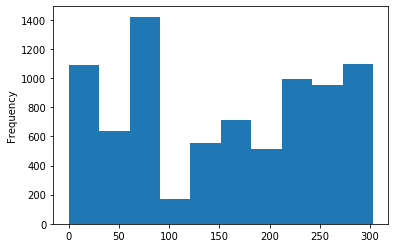

In [31]:
data['Publisher'].plot(kind='hist')

### Developer

In [32]:
print("Size of Domain: ",len(data['Developer'].unique()))
print("Type of Domain:",data['Developer'].dtypes)
# print(data['Publisher'].unique())
print("Number of null values: ",data['Developer'].isnull().sum())

Size of Domain:  1467
Type of Domain: object
Number of null values:  6


#### We see that we need to do something very similar to what we did for Publisher, which is Label Encoding

In [33]:
num=[]
for i in data['Developer'].unique():
    if( isinstance(i, int) == 1 or isinstance(i, float) ==1):
        print(i)
        num.append(i)

nan


In [34]:
for i in num:
    data['Developer'] = data['Developer'].replace(i,"zero")

In [35]:
lc = LabelEncoder()

data['Developer'] = lc.fit_transform(data['Developer'])

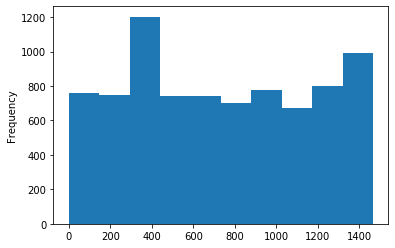

In [36]:
data['Developer'].plot(kind='hist')

### Rating

In [37]:
print(data['Rating'].unique())
data['Rating'].dtypes

['E' 'M' 'T' 'E10+' nan 'AO' 'K-A' 'RP']


dtype('O')

In [38]:
group_by_rating = data.groupby(by=['Rating'])
rating_data_avg = group_by_rating.mean()
rating_data_count = group_by_rating.count()
rating_data_count

,Name,Platform,Year_of_Release,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,...,FightingGenre,MiscGenre,PlatformGenre,PuzzleGenre,RacingGenre,Role-PlayingGenre,ShooterGenre,SimulationGenre,SportsGenre,StrategyGenre
Rating,,,,,,,,,,,,,,,,,,,,,
AO,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
E,2808,2808,2756,2808,2808,2808,2808,2808,2808,2808,...,2808,2808,2808,2808,2808,2808,2808,2808,2808,2808
E10+,1118,1118,1097,1118,1118,1118,1118,1118,1118,1118,...,1118,1118,1118,1118,1118,1118,1118,1118,1118,1118
K-A,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
M,1483,1483,1457,1483,1483,1483,1483,1483,1483,1483,...,1483,1483,1483,1483,1483,1483,1483,1483,1483,1483
RP,3,3,1,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
T,2640,2640,2589,2640,2640,2640,2640,2640,2640,2640,...,2640,2640,2640,2640,2640,2640,2640,2640,2640,2640


In [39]:
data_count_series = rating_data_count.iloc[:,0]

features_of_interest = pd.DataFrame({'Critic_Score':rating_data_avg['Critic_Score'],'No. Games':data_count_series})

features_of_interest

,Critic_Score,No. Games
Rating,,
AO,93.000000,1
E,68.484687,2808
E10+,66.759392,1118
K-A,92.000000,1
M,71.797033,1483
RP,62.000000,3
T,68.828409,2640


#### Encoding: Since the size of the domain is less, we can safely One Hot Encode this data.

In [40]:
num=[]
for i in data['Rating'].unique():
    if( isinstance(i, int) == 1 or isinstance(i, float) ==1):
        print(i)
        num.append(i)

nan


In [41]:
for i in num:
    data['Rating'] = data['Rating'].replace(i,"zero")

In [42]:
encoded_columns = pd.get_dummies(data['Rating'])

for i in encoded_columns:
    data[i] = encoded_columns[i]
data = data.drop(columns=['Rating'],axis=1)
data.shape

(8137, 45)

### User Score

In [43]:
data['User_Score'].unique()

array(['8', '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4', '8.2',
       '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2', '8.9',
       '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3', '7.6',
       '5.7', '5', '9.1', '6.5', '8.8', '6.9', '9.4', '6.8', '6.1', '6.7',
       '5.4', nan, '4', '9.3', '6.2', '4.2', '6', 'tbd', '4.9', '3.7',
       '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9', '3.1',
       '2.9', '5.2', '3.3', '4.5', '5.1', '3.5', '2.5', '1.9', '2.2', '2',
       '9.5', '4.7', '2.1', '3.6', '1.8', '3.8', '3', '9.6', '2.8', '1.7',
       '2.7', '2.4', '1.5', '1.2', '2.3', '0.5', '0.6', '0.9', '1', '1.4',
       '1.3', '0.7'], dtype=object)

#### We can see that except for nan, 'tbd' the rest of the values are all numbers.

In [44]:
print(data['User_Score'].isnull().sum())

38


#### We can convert User_Score column into a numerical column. We replace the illegal values with mean as there are very few values.

In [45]:
data['User_Score'] = pd.to_numeric(data['User_Score'], errors='coerce')

data['User_Score'] = data['User_Score'].replace(np.nan, 0 , regex=True)  
data['User_Score'] = data['User_Score'].astype(float)

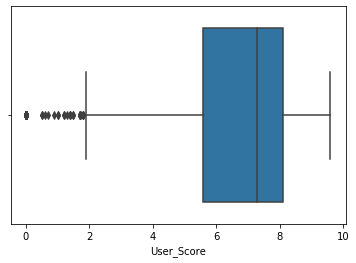

In [46]:
sns.boxplot(x=data['User_Score'])

In [47]:
data.head(2)

,Name,Platform,Year_of_Release,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,...,SportsGenre,StrategyGenre,AO,E,E10+,K-A,M,RP,T,zero
0,Wii Sports,12,2006.0,185,41.36,28.96,3.77,8.45,82.53,76.0,...,1,0,0,1,0,0,0,0,0,0
2,Mario Kart Wii,12,2008.0,185,15.68,12.76,3.79,3.29,35.52,82.0,...,0,0,0,1,0,0,0,0,0,0


### Other Numerical features - Global_Sales, EU_Sales ...

In [48]:
data['Platform'].unique()

array([12,  2, 14,  8,  7,  0,  9,  6, 15,  5, 10, 13,  4,  3, 16, 11,  1])

#### We can also use our sampler/mean to fill the missing values in all the numerical columns

In [49]:
# Using Sampler/mean for each column 

for i in list(data.columns):
    if(data[i].dtypes != 'object'):
        data[i] = data[i].fillna(data[i].mean())
#         replace_null(i,data)

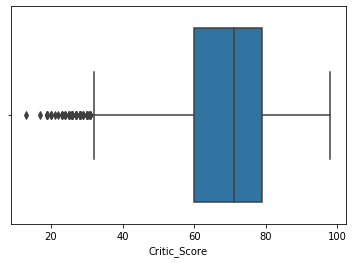

In [50]:
sns.boxplot(x=data['Critic_Score'])

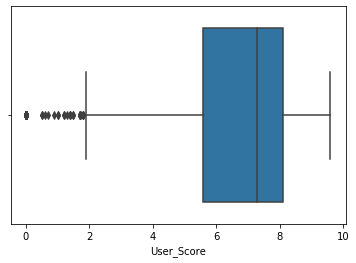

In [51]:
sns.boxplot(x=data['User_Score'])

#### It can be seen that generally people are a little more generous with their scores compared to critics.

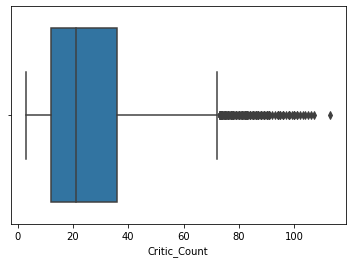

In [52]:
sns.boxplot(x=data['Critic_Count'])

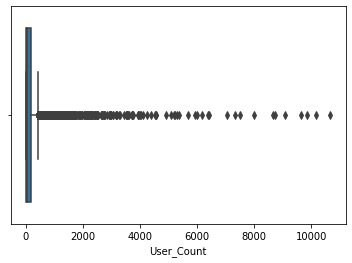

In [53]:
sns.boxplot(x=data['User_Count'])

### Illegal value analysis for features

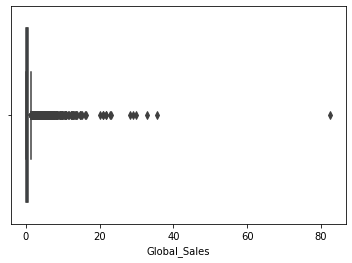

In [54]:
sns.boxplot(x=data['Global_Sales'])

In [55]:
data[data['Global_Sales'] > 60]

,Name,Platform,Year_of_Release,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,...,SportsGenre,StrategyGenre,AO,E,E10+,K-A,M,RP,T,zero
0,Wii Sports,12,2006.0,185,41.36,28.96,3.77,8.45,82.53,76.0,...,1,0,0,1,0,0,0,0,0,0


#### This game is a special case as it was given for free to all customers who bought the Wii console (which is one of the most popular consoles of all time). It is an outlier.

In [56]:
indexNames = data[ data['Global_Sales'] > 60 ].index
 
# Delete these row indexes from dataFrame
data.drop(indexNames , inplace=True)

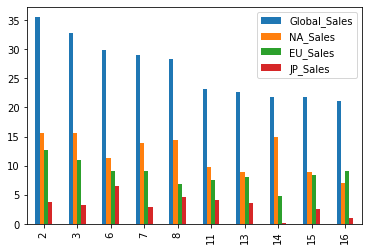

In [57]:
plotting = pd.DataFrame(data['Global_Sales'])
plotting['NA_Sales'] = data['NA_Sales']
plotting['EU_Sales'] = data['EU_Sales']
plotting['JP_Sales'] = data['JP_Sales']
plotting.head(10).plot(kind='bar')

### Correlation matrix and heat maps

In [58]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

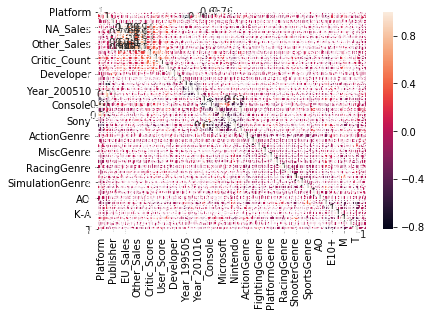

In [59]:
sns.heatmap(data.corr(), annot=True)

### Train Test Split for Critic Score

In [60]:
train, test = train_test_split(data, test_size=0.33,random_state=6)

In [61]:
x_train = train.drop(['Name','User_Score','Global_Sales','NA_Sales','EU_Sales','JP_Sales','Other_Sales'],axis=1)
y_train1 = train['User_Score']
y_train2 = train['Global_Sales']
y_train3 = train['NA_Sales']
y_train4 = train['EU_Sales']
y_train5 = train['JP_Sales']

x_test = test.drop(['Name','User_Score','Global_Sales','NA_Sales','EU_Sales','JP_Sales','Other_Sales'],axis=1)
y_test1 = test['User_Score']
y_test2 = test['Global_Sales']
y_test3 = test['NA_Sales']
y_test4 = test['EU_Sales']
y_test5 = test['JP_Sales']

### Scaling the Data set

#### If we perform only Linear Regression, it is not necessary to scale the feature set, however, it is very useful for interpretability fo the data

In [62]:
scaler = StandardScaler() 

scaler.fit(x_train)

x_train = scaler.transform(x_train)

x_test = scaler.transform(x_test)

## Model Training and Error Evaluation

In [63]:
#Creating model
modellir = Ridge()

# Fitting the model with prepared data
modellir.fit(x_train,y_train1)
y_predlir = modellir.predict(x_test)


In [64]:
print("Ridge Regression RMSE (User Score):", sqrt(mean_squared_error(y_test1,y_predlir)))
print("Ridge Regression R2 Score (User Score):", r2_score(y_test1,y_predlir))

Ridge Regression RMSE (User Score): 2.315152146049301
Ridge Regression R2 Score (User Score): 0.33406573955813257


In [65]:
modellir.fit(x_train,y_train2)
y_predlir = modellir.predict(x_test)

In [66]:
print("Ridge Regression RMSE (Global Sales):", sqrt(mean_squared_error(y_test2,y_predlir)))
print("Ridge Regression R2 Score (Global Sales):", r2_score(y_test2,y_predlir))

Ridge Regression RMSE (Global Sales): 1.5462780504537277
Ridge Regression R2 Score (Global Sales): 0.1913534332277942


In [67]:
modellir.fit(x_train,y_train3)
y_predlir = modellir.predict(x_test)

print("Linear Regression RMSE (NA Sales):", sqrt(mean_squared_error(y_test3,y_predlir)))
print("Linear Regression R2 Score (NA Sales):", r2_score(y_test3,y_predlir))

Linear Regression RMSE (NA Sales): 0.7323070083231055
Linear Regression R2 Score (NA Sales): 0.1874498909918716


In [68]:
modellir.fit(x_train,y_train4)
y_predlir = modellir.predict(x_test)

print("Ridge Regression RMSE (EU Sales):", sqrt(mean_squared_error(y_test4,y_predlir)))
print("Ridge Regression R2 Score (EU Sales):", r2_score(y_test4,y_predlir))

Ridge Regression RMSE (EU Sales): 0.5424499796923218
Ridge Regression R2 Score (EU Sales): 0.16369286009323802


In [69]:
modellir.fit(x_train,y_train5)
y_predlir = modellir.predict(x_test)

print("Ridge Regression RMSE (JP Sales):", sqrt(mean_squared_error(y_test5,y_predlir)))
print("Ridge Regression R2 Score (JP Sales):", r2_score(y_test5,y_predlir))

Ridge Regression RMSE (JP Sales): 0.2780761804057319
Ridge Regression R2 Score (JP Sales): 0.0978042005200237


### Residual Plot

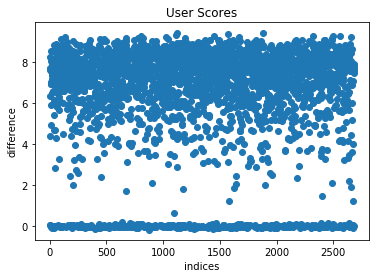

In [70]:
plt.scatter(range(0,len(y_test1-y_predlir)),(y_test1-y_predlir)) 

plt.xlabel('indices') 
plt.ylabel('difference') 
   
plt.title('User Scores') 
  
plt.show() 

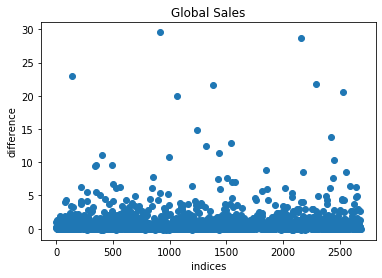

In [71]:
plt.scatter(range(0,len(y_test2-y_predlir)),(y_test2-y_predlir)) 

plt.xlabel('indices') 
plt.ylabel('difference') 
   
plt.title('Global Sales') 
  
plt.show() 

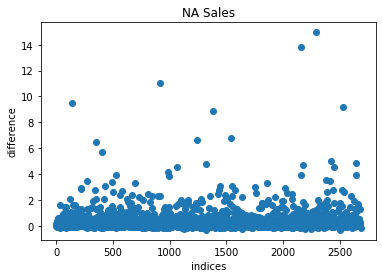

In [72]:
plt.scatter(range(0,len(y_test3-y_predlir)),(y_test3-y_predlir)) 

plt.xlabel('indices') 
plt.ylabel('difference') 
   
plt.title('NA Sales') 
  
plt.show() 

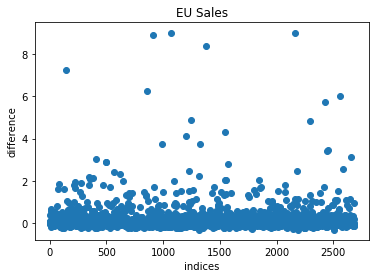

In [73]:
plt.scatter(range(0,len(y_test4-y_predlir)),(y_test4-y_predlir)) 

plt.xlabel('indices') 
plt.ylabel('difference') 
   
plt.title('EU Sales') 
  
plt.show() 

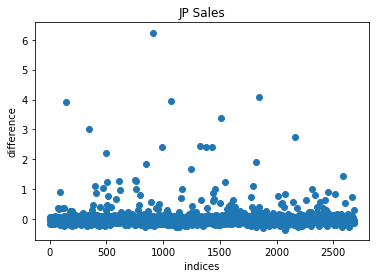

In [74]:
plt.scatter(range(0,len(y_test5-y_predlir)),(y_test5-y_predlir)) 

plt.xlabel('indices') 
plt.ylabel('difference') 
   
plt.title('JP Sales') 
  
plt.show() 

#### This plot gives us a much better idea as to how large a difference the errors are.

## The END

### Creating Pickle file

In [75]:
import pickle

file_Name = "model"

fileObject = open(file_Name, 'wb')

pickle.dump(modellir, fileObject)

fileObject.close()

## EXTRA:

### Error Evaluation without Feature Engineering and Preprocessing

In [76]:
# data = pd.read_csv("Video_Games_Sales_as_at_22_Dec_2016.csv")

# data = data.dropna(subset=['Critic_Score'])

# for i in list(data.columns):
#     if(data[i].dtypes != 'object'):
#         data[i].fillna(data[i].mean())

# data['User_Score'] = pd.to_numeric(data['User_Score'], errors='coerce')

# data = data.replace(np.nan, 0 , regex=True)  
# data['User_Score'] = data['User_Score'].astype(float)

# data['User_Score'].dtypes

# for s in list(data.columns):
#     if(data[s].dtypes == 'object'):
#         num=[]
#         for i in data[s].unique():
#             if( isinstance(i, int) == 1 or isinstance(i, float) ==1):
# #                 print(i)
#                 num.append(i)

# #### This shows that there is a 0 in the dataset where there should be a string. We shall replace it with the string 'zero'

#         for i in num:
#             data[s] = data[s].replace(i,"zero")




# lc = LabelEncoder()
# for s in list(data.columns):
#     if(data[s].dtypes == 'object'):
# #         print(data[s])
#         data[s] = lc.fit_transform(data[s])

# train, test = train_test_split(data, test_size=0.33,random_state=6)

# x_train = train.drop(['Name','User_Score','Global_Sales','NA_Sales','EU_Sales','JP_Sales','Other_Sales'],axis=1)
# y_train1 = train['User_Score']
# y_train2 = train['Global_Sales']
# y_train3 = train['NA_Sales']
# y_train4 = train['EU_Sales']
# y_train5 = train['JP_Sales']

# x_test = test.drop(['Name','User_Score','Global_Sales','NA_Sales','EU_Sales','JP_Sales','Other_Sales'],axis=1)
# y_test1 = test['User_Score']
# y_test2 = test['Global_Sales']
# y_test3 = test['NA_Sales']
# y_test4 = test['EU_Sales']
# y_test5 = test['JP_Sales']
# scaler = StandardScaler() 

# scaler.fit(x_train)

# x_train = scaler.transform(x_train)

# x_test = scaler.transform(x_test)

# ## Model Training and Error Evaluation

# #Creating model
# modellir = Lasso()

# # Fitting the model with prepared data
# modellir.fit(x_train,y_train1)
# y_predlir = modellir.predict(x_test)


# print("Linear Regression RMSE (User Score):", sqrt(mean_squared_error(y_test1,y_predlir)))
# print("Linear Regression R2 Score (User Score):", r2_score(y_test1,y_predlir))

# modellir.fit(x_train,y_train2)
# y_predlir = modellir.predict(x_test)

# print("Linear Regression RMSE (Global Sales):", sqrt(mean_squared_error(y_test2,y_predlir)))
# print("Linear Regression R2 Score (Global Sales):", r2_score(y_test2,y_predlir))

# modellir.fit(x_train,y_train3)
# y_predlir = modellir.predict(x_test)

# print("Linear Regression RMSE (NA Sales):", sqrt(mean_squared_error(y_test3,y_predlir)))
# print("Linear Regression R2 Score (NA Sales):", r2_score(y_test3,y_predlir))

# modellir.fit(x_train,y_train4)
# y_predlir = modellir.predict(x_test)

# print("Linear Regression RMSE (EU Sales):", sqrt(mean_squared_error(y_test4,y_predlir)))
# print("Linear Regression R2 Score (EU Sales):", r2_score(y_test4,y_predlir))

# modellir.fit(x_train,y_train5)
# y_predlir = modellir.predict(x_test)

# print("Linear Regression RMSE (JP Sales):", sqrt(mean_squared_error(y_test5,y_predlir)))
# print("Linear Regression R2 Score (JP Sales):", r2_score(y_test5,y_predlir))